# Benchmarking Code and Plots

In [1]:
import os
import importlib
from PIL import Image
from tqdm import tqdm
# import test_utils
#  # replace with actual import if needed
# importlib.reload(test_utils)
# from test_utils import calculate_metrics_batch 

import re
import os
from pathlib import Path
import pandas as pd
from typing import Dict, List, Optional,Union

## HEVC and H264 Evaluation

In [2]:
data = pd.read_csv('metrics/UVG_gop_ablation_q4.csv')
data= data.groupby('gop', as_index=False).mean(numeric_only=True)

,gop,Unnamed: 0,PSNR,MS-SSIM,LPIPS,FID,FVD,intra_kb,flow_kb,total_storage,total_bits,bpp
0,gop16,11.0,19.928766,0.652998,0.233092,3.116375,7.561435e+06,315.122857,1946.965681,2262.088538,1.853103e+07,0.092130
1,gop4,9.0,24.648297,0.772539,0.166717,2.333725,1.252516e+07,1132.928571,1557.572545,2690.501116,2.204059e+07,0.109579
2,gop8,10.0,21.828893,0.722580,0.199486,2.653734,9.095904e+06,587.401429,1817.167969,2404.569397,1.969823e+07,0.097933


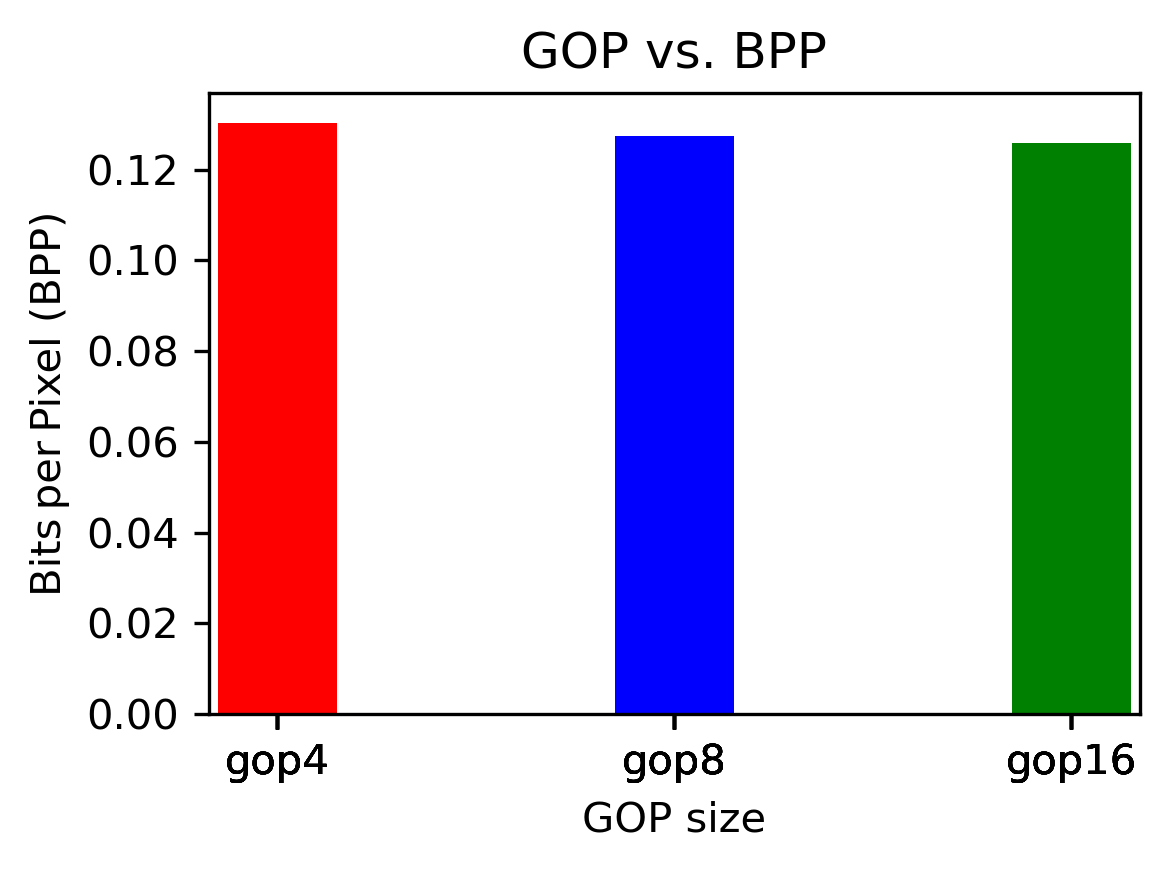

In [10]:

fig, ax = plt.subplots(figsize=(4, 3),dpi=300)
colors = ['red', 'blue', 'green']
ax.bar(data["gop"], data["bpp"],color=colors, width=0.3)

ax.set_xlabel("GOP size")
ax.set_ylabel("Bits per Pixel (BPP)")
ax.set_title("GOP vs. BPP")
ax.set_xticks(data["gop"])           # show every GOP value on the x‑axis
ax.margins(x=0.01)

plt.tight_layout()
plt.show()


In [3]:

# === Your evaluation function (should be defined elsewhere) ===
# def calculate_metrics_batch(orig_images, pred_images) -> Dict[str, float]:
#     return {"PSNR": ..., "MS-SSIM": ..., "LPIPS": ..., "FID": ..., "FVD": ...}

# === Config ===
BASE_PRED = Path("test_codec")
BASE_ORIG = Path("../data/UVG")
output_csv = "metrics_results_h265.csv"

# === Core Functions ===

def load_images_from_folder(folder: Path):
    return [Image.open(f) for f in sorted(folder.glob("*.png"))]

def evaluate_crf(video: str, crf_dir: Path, orig_frames: list):
    pred_frames = load_images_from_folder(crf_dir)
    min_len = min(len(orig_frames), len(pred_frames))
    if min_len == 0:
        return []
    metrics = calculate_metrics_batch(orig_frames[:min_len], pred_frames[:min_len])
    return [
        f"{video},{crf_dir.name},"
        f"{metrics['PSNR']:.4f},{metrics['MS-SSIM']:.4f},"
        f"{metrics['LPIPS']:.4f},{metrics['FID']:.4f},{metrics['FVD']:.4f}"
    ]

def evaluate_video(video_dir: Path, orig_base: Path):
    # print(video_name)
    video_name = video_dir.name
    crf_root = video_dir / "h265"
    orig_path = orig_base / video_name / "1080p"
    print(video_name, orig_path, crf_root )
    if not crf_root.is_dir() or not orig_path.is_dir():
        return []

    orig_frames = load_images_from_folder(orig_path)
    results = []

    for crf in tqdm(sorted(['bpp0.01', 'bpp0.05','bpp0.1']), desc=f"{video_name} CRFs", leave=False):
        crf_dir = crf_root / crf 
        print(crf_dir, crf_dir.is_dir())
        if crf_dir.is_dir():
            row = evaluate_crf(video_name, crf_dir, orig_frames)
            if row:
                results.append(row)

    return results

# === Main ===

def main():
    all_results = []

    for video_dir in tqdm(sorted(BASE_PRED.iterdir()), desc="Videos"):
        if video_dir.is_dir():
            all_results.extend(evaluate_video(video_dir, BASE_ORIG))

    # Save to file
    parsed_results = [line.split(",") for line in all_results]

    # Create DataFrame
    df = pd.DataFrame(parsed_results, columns=["Video", "CRF", "PSNR", "MS-SSIM", "LPIPS", "FID", "FVD"])

    # (Optional) Convert numerical columns to float
    for col in ["PSNR", "MS-SSIM", "LPIPS", "FID", "FVD"]:
        df[col] = df[col].astype(float)

    df.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

if __name__ == "__main__":
    main()


Videos:   0%|                                                                                    | 0/7 [00:00<?, ?it/s]

Beauty ../data/UVG/Beauty/1080p test_codec/Beauty/h265



uty CRFs:   0%|                                                                               | 0/3 [00:00<?, ?it/s]

test_codec/Beauty/h265/bpp0.01 True



Videos:   0%|                                                                                    | 0/7 [00:08<?, ?it/s]


NameError: name 'calculate_metrics_batch' is not defined

In [ ]:
def attach_bpp(df_grouped: pd.DataFrame, bpp_df: pd.DataFrame, codec_name: str) -> pd.DataFrame:
    """Attach BPP column to a grouped codec DataFrame based on codec name."""
    bpp_values = bpp_df.loc[bpp_df['Codec'] == codec_name, 'BPP'].values
    df_grouped = df_grouped.copy()
    df_grouped['BPP'] = bpp_values
    return df_grouped

def save_codec_metrics(df_grouped: pd.DataFrame, codec_name: str, out_dir: str = "benchmark"):
    """Save codec metrics with BPP to a CSV file."""
    filename = f"{out_dir}/{codec_name}_gop8_benchmarking.csv"
    df_grouped.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")

# === Usage ===
h264_grouped = attach_bpp(h264_grouped, bpp_df, "h264")
h265_grouped = attach_bpp(h265_grouped, bpp_df, "h265")

# Save results
save_codec_metrics(h264_grouped, "h264")
save_codec_metrics(h265_grouped, "h265")

## UniControl Bpp Calculation

In [ ]:
# ---------- generic helpers --------------------------------------------------
KB = 1024.0
TOTAL_FRAMES = 97          # change if your dataset differs
GOPS          = (4, 8, 16) # gops you care about

def read_frame_sizes(report_path: Path) -> Dict[int, float]:
    """
    Return {frame_index: size_kb} from one compression_report.txt.
    Accepts either of the two formats you showed.

      frame_0000.png → 74.69 KB
      - frame_0000.png: 74.69 KB
    """
    if not report_path.is_file():
        raise FileNotFoundError(report_path)

    pat_arrow = re.compile(r"frame_(\d{4})\.png\s*→\s*([\d.]+)\s*KB")
    pat_colon = re.compile(r"frame_(\d{4})\.png:\s*([\d.]+)\s*KB")

    sizes = {}
    for line in report_path.read_text().splitlines():
        m = pat_arrow.search(line) or pat_colon.search(line)
        if m:
            idx, kb = m.groups()
            sizes[int(idx)] = float(kb)
    return sizes


def intra_storage_kb(frame_sizes: Dict[int, float],
                     gop: int,
                     total_frames: int = TOTAL_FRAMES) -> float:
    """Sum sizes of every gop-th frame starting from 0."""
    return sum(frame_sizes.get(i, 0.0) for i in range(0, total_frames, gop))


# ---------- optical-flow helpers ---------------------------------------------
def first_bin_size_kb(flow_dir: Path) -> Optional[float]:
    """Return size (KB) of first .bin inside a folder, or None."""
    for f in flow_dir.iterdir():
        if f.suffix == ".bin":
            return f.stat().st_size / KB
    return None


def flow_storage_kb(video_1080p: Path, gop: int,
                    fallback_size_kb: Optional[float]) -> float:
    """
    Estimate total flow storage as  (#png) × (size of one .bin).

    If this GOP has no .bin, uses fallback_size_kb (often GOP-8 size).
    """
    flow_dir = video_1080p / f"optical_flow_gop_{gop}"
    if not flow_dir.is_dir():
        return 0.0

    size_kb = first_bin_size_kb(flow_dir) or fallback_size_kb or 0.0
    num_png = len([p for p in flow_dir.iterdir() if p.suffix == ".png"])
    return size_kb * num_png


# ---------- one-video processing ---------------------------------------------
def process_one_video(video_dir: Path,
                      decoded_sub = "decoded_q4",
                      gops       = GOPS) -> List[Dict]:
    """
    Returns a list of rows (one per gop) with keys:
      video • gop • intra_kb • flow_kb
    """
    rows = []
    # ---- intra-frame sizes ---------------------------------------------------
    report = video_dir / "1080p" / decoded_sub / "compression_report.txt"
    try:
        f_sizes = read_frame_sizes(report)
    except FileNotFoundError:
        print(f"⚠️  missing report: {report}")
        return rows

    # ---- optical-flow bin fallback (prefer gop-8) ---------------------------
    g8_dir = video_dir / "1080p" / "optical_flow_gop_8"
    fallback_kb = first_bin_size_kb(g8_dir)

    # ---- per-GOP aggregation -------------------------------------------------
    for g in gops:
        rows.append(
            dict(
                video=video_dir.name,
                gop=f"gop{g}",
                intra_kb=intra_storage_kb(f_sizes, g),
                flow_kb=flow_storage_kb(video_dir / "1080p", g, fallback_kb),
            )
        )
    return rows


# ---------- dataset-wide driver ----------------------------------------------
def build_storage_dataframe(base_dir: Union[str, Path],
                            decoded_sub = "decoded_q4",
                            gops       = GOPS) -> pd.DataFrame:
    records = []
    base = Path(base_dir)
    for video_dir in sorted(base.iterdir()):
        if video_dir.is_dir():
            records.extend(process_one_video(video_dir,
                                             decoded_sub=decoded_sub,
                                             gops=gops))
    df = pd.DataFrame(records)
    # Optional pivot to wide format (one row per video)
    #   df = df.pivot(index="video", columns="gop", values=["intra_kb","flow_kb"])
    return df


# ---------------- run ---------------------------------------------------------
if __name__ == "__main__":
    df = build_storage_dataframe("../data/UVG")   # adjust path if needed
    print(df.head())

## UniControl Metric Calculation

In [ ]:
import json
import pandas as pd
from pathlib import Path


def load_json_metrics(json_paths, gops):
    """Load and flatten JSON metric files into a single DataFrame."""
    all_metrics = []

    for path, gop in zip(json_paths, gops):
        json_path = Path(path)
        if json_path.exists():
            with open(json_path, 'r') as f:
                data = json.load(f)
                for video, metrics in data.items():
                    metrics.update(video=video, gop=gop)
                    all_metrics.append(metrics)
        else:
            print(f"⚠️ JSON not found: {json_path}")

    return pd.DataFrame(all_metrics)


def compute_flow_storage(df, grid_id=3):
    """Add flow_storage (in bytes) per video-gop based on bpp_report.txt."""
    df["flow_storage"] = 0

    for idx, row in df.iterrows():
        video = row["video"]
        gop = row["gop"]
        report_path = Path(f"../data/UVG/{video}/1080p/optical_flow_gop_{gop}/grid_{grid_id}/bpp_report.txt")
        print(report_path, report_path.exists())
        total = 0
        if report_path.exists():
            with open(report_path, 'r') as f:
                for line in f:
                    if ':' in line and 'bytes' in line:
                        try:
                            size = int(line.split(':')[1].split()[0])
                            total += size
                        except Exception:
                            continue
        df.at[idx, "flow_storage"] = total

    return df


def load_intra_storage(csv_path):
    """Load intra CSV and convert KB to bytes."""
    df_intra = pd.read_csv(csv_path)
    df_intra["intra_bytes"] = df_intra["intra_kb"] * 1024
    # Optional: convert 'gop4' → 4
    df_intra["gop"] = df_intra["gop"].str.extract(r"(\d+)").astype(int)
    return df_intra


def merge_and_compute_bpp(df, df_intra, resolution=(1920, 1080), num_frames=97):
    """Merge with intra storage, then compute total storage, bits, and bpp."""
    df["gop"] = df["gop"].astype(int)
    df_merged = pd.merge(df, df_intra[["video", "gop", "intra_bytes"]], on=["video", "gop"], how="left")

    df_merged["total_storage"] = df_merged["intra_bytes"] + df_merged["flow_storage"]
    df_merged["total_bits"] = df_merged["total_storage"] * 8

    total_pixels = resolution[0] * resolution[1] * num_frames
    df_merged["bpp"] = df_merged["total_bits"] / total_pixels

    return df_merged


def main():
    json_paths = [
        "./unicontrol_codec_grid15/all_videos_metrics_1080p_q4_4.json",
        "./unicontrol_codec_grid15/all_videos_metrics_1080p_q4_8.json",
        "./unicontrol_codec_grid15/all_videos_metrics_1080p_q4_16.json"
    ]
    gops = [4, 8, 16]

    # Step 1: Load metrics from JSON
    df_metrics = load_json_metrics(json_paths, gops)

    # Step 2: Compute flow storage from bpp reports
    df_metrics = compute_flow_storage(df_metrics, grid_id=15)

    # Step 3: Load intra storage
    df_intra = load_intra_storage("./metrics/intra_uvg.csv")

    # Step 4: Merge and calculate bpp
    df_combined = merge_and_compute_bpp(df_metrics, df_intra)

    # Show result
    print(df_combined.head())

    # Optional: save
    df_combined.to_csv("metrics/Unicontrol_UVG_1080_grid15.csv", index=False)


if __name__ == "__main__":
    main()
